# Sustainable AI: Energy-Efficient Prompt Engineering

This notebook supports the development of a machine learning model that predicts the energy usage of language model inference tasks based on prompt characteristics. The goal is to help optimize prompt inputs and improve transparency in AI system energy consumption.

**Dataset**: [improved_prompts.csv] created from the NLP_script.ipynb Jupyter Notebook and can be found under the [data] directory.


## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Extra ML libs
%pip install lightgbm

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Loading the dataset

In [34]:
# Update the path if your CSV has a different name
CSV_PATH = "../data/improved_prompts.csv"

df = pd.read_csv(CSV_PATH)
print(f"✅ Loaded {len(df)} rows from {CSV_PATH}")
print("Columns:", list(df.columns))

# required columns for this workflow
required_cols = {"original_prompt", "verb_count", "original_energy", "optimized_prompt", "optimized_energy"}
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in dataset: {missing}")

# add energy_difference if not present
if "energy_difference" not in df.columns:
    df["energy_difference"] = df["original_energy"] - df["optimized_energy"]

df.head(3)


✅ Loaded 68 rows from ../data/improved_prompts.csv
Columns: ['original_prompt', 'optimized_prompt', 'token_length', 'verb_count', 'original_energy', 'optimized_energy', 'energy_difference']


,original_prompt,optimized_prompt,token_length,verb_count,original_energy,optimized_energy,energy_difference
0,What is the main benefit of using a natural la...,What is the main benefit of using a natural la...,37,1.0,0.001970,0.001387,0.000583
1,Create a 5-item shopping list for a healthy br...,Create a 5-item shopping list for a healthy br...,42,1.0,0.003360,0.001813,0.001547
2,Rearrange the words to create a complete sente...,Rearrange the words to create a complete sente...,45,2.0,0.001862,0.001435,0.000427


## Basic EDA about the verb and token counts


📊 Descriptive stats:


,verb_count,token_length_original,energy_difference
count,68.000000,68.000000,68.000000
mean,2.132353,14.529412,0.001139
std,1.232694,7.249232,0.000762
min,0.000000,8.000000,0.000132
25%,1.000000,10.000000,0.000493
50%,2.000000,12.000000,0.001013
75%,3.000000,15.500000,0.001620
max,5.000000,48.000000,0.002849


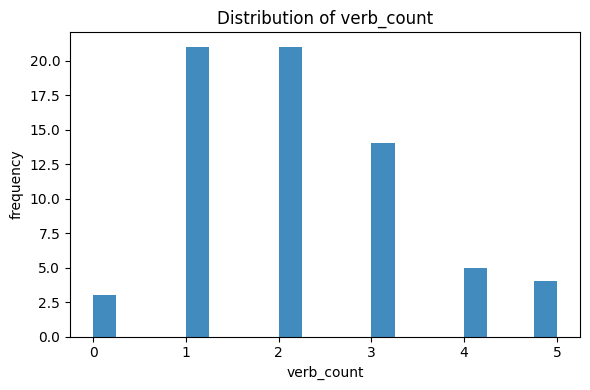

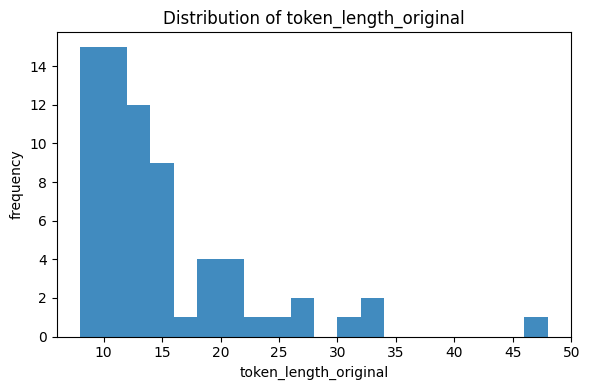

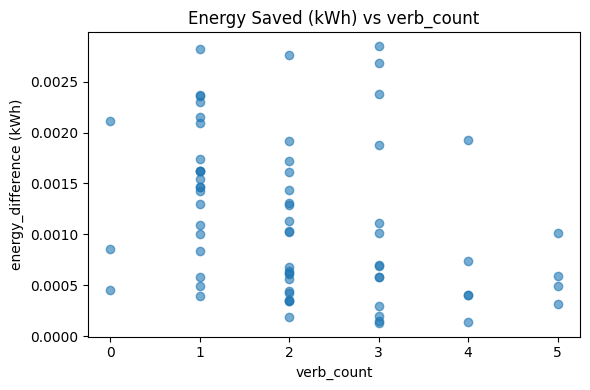

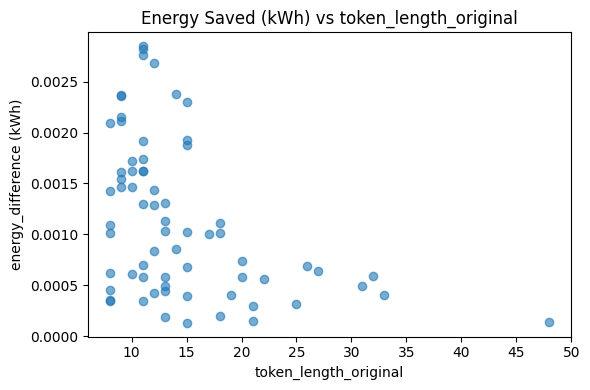

In [35]:
# simple whitespace tokenization for the ORIGINAL prompt
def token_len(text: str) -> int:
    text = "" if pd.isna(text) else str(text)
    return len(text.split())

# derive token_length_original
df["token_length_original"] = df["original_prompt"].map(token_len).astype(int)

print("\n📊 Descriptive stats:")
display(df[["verb_count", "token_length_original", "energy_difference"]].describe())

# Plot distributions (one chart per figure)
plt.figure(figsize=(6,4))
plt.hist(df["verb_count"].dropna(), bins=20, alpha=0.85)
plt.title("Distribution of verb_count")
plt.xlabel("verb_count")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["token_length_original"].dropna(), bins=20, alpha=0.85)
plt.title("Distribution of token_length_original")
plt.xlabel("token_length_original")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

# Scatter relationships
plt.figure(figsize=(6,4))
plt.scatter(df["verb_count"], df["energy_difference"], alpha=0.6)
plt.title("Energy Saved (kWh) vs verb_count")
plt.xlabel("verb_count")
plt.ylabel("energy_difference (kWh)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["token_length_original"], df["energy_difference"], alpha=0.6)
plt.title("Energy Saved (kWh) vs token_length_original")
plt.xlabel("token_length_original")
plt.ylabel("energy_difference (kWh)")
plt.tight_layout()
plt.show()


## Computing averages per count

In [ ]:
FEATURE_COL = "verb_count" if "verb_count" in df.columns else "token_length_original"
TARGET_COL = "energy_difference"  # assumes this exists; else compute initial-final beforehand

df_avg = (
    df[[FEATURE_COL, TARGET_COL]]
    .dropna()
    .groupby(FEATURE_COL, as_index=False)[TARGET_COL]
    .mean()
    .rename(columns={TARGET_COL: "avg_energy_difference"})
    .sort_values(FEATURE_COL)
    .reset_index(drop=True)
)

print(f"Using feature: {FEATURE_COL}")
display(df_avg.head())

Using feature: verb_count


,verb_count,avg_energy_difference
0,0.0,0.001142
1,1.0,0.001538
2,2.0,0.000975
3,3.0,0.001089
4,4.0,0.000722


## Plotting average energy difference vs count

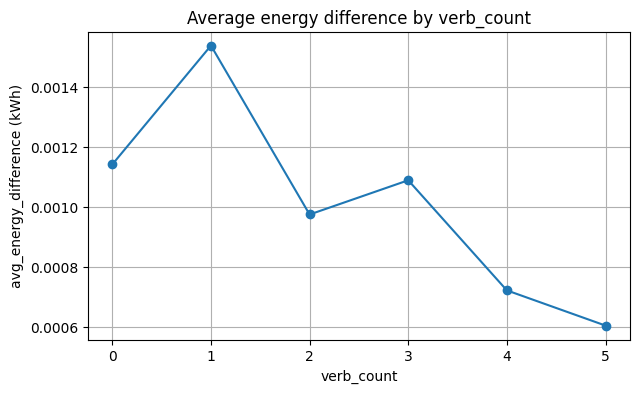

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_avg[FEATURE_COL], df_avg["avg_energy_difference"], marker="o")
plt.xlabel(FEATURE_COL)
plt.ylabel("avg_energy_difference (kWh)")
plt.title(f"Average energy difference by {FEATURE_COL}")
plt.grid(True)
plt.show()

## Preparing average data

In [59]:
FEATURE_COL = "verb_count"
TARGET_COL  = "avg_energy_difference"

X_all = df_avg[FEATURE_COL].to_numpy(dtype=float)
y_all = df_avg[TARGET_COL].to_numpy(dtype=float)

## Fitting exponential offset

In [ ]:
def fit_exp_offset_linearized(x, y):
    c_candidates = [0.0] + list(np.quantile(y, [0.05, 0.1, 0.2]))
    best = None
    for c in c_candidates:
        y_shift = y - c
        if np.any(y_shift <= 0):
            continue
        z = np.log(y_shift)
        A = np.column_stack([np.ones_like(x), -x])  # z = log a - b x
        theta, *_ = np.linalg.lstsq(A, z, rcond=None)
        log_a, b = theta
        a = np.exp(log_a)
        y_hat = c + a * np.exp(-b * x)
        mae = mean_absolute_error(y, y_hat)
        cand = {"a": float(a), "b": float(b), "c": float(c), "mae": float(mae)}
        if best is None or mae < best["mae"]:
            best = cand
    return best

fit = fit_exp_offset_linearized(X_all, y_all)
a_opt, b_opt, c_opt = fit["a"], fit["b"], fit["c"]
print(f"Fitted Exponential (offset) on all data: a={a_opt:.6g}, b={b_opt:.6g}, c={c_opt:.6g} | MAE(all)={fit['mae']:.6f}")

✅ Fitted Exponential (offset) on all data: a=0.00141461, b=0.152591, c=0 | MAE(all)=0.000160


## Creating the predictor

In [ ]:
def predict_energy_saving_from_verbs(v_count: float) -> float:
    """Predict energy difference (kWh) from verb_count using fitted exponential with offset."""
    return c_opt + a_opt * np.exp(-b_opt * float(v_count))

# Quick sanity checks
for v in sorted(np.unique(X_all))[:5]:
    print(f"verbs={int(v):2d} -> pred Δenergy={predict_energy_saving_from_verbs(v):.6f} kWh")

verbs= 0 -> pred Δenergy=0.001415 kWh
verbs= 1 -> pred Δenergy=0.001214 kWh
verbs= 2 -> pred Δenergy=0.001043 kWh
verbs= 3 -> pred Δenergy=0.000895 kWh
verbs= 4 -> pred Δenergy=0.000768 kWh


## Plotting final curve

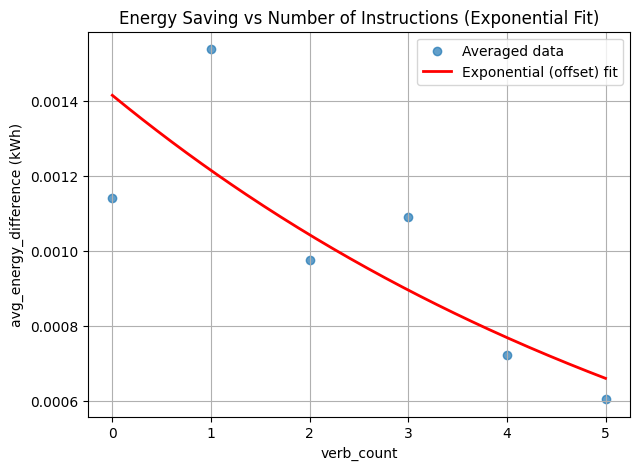

In [ ]:
x_line = np.linspace(X_all.min(), X_all.max(), 200)
y_line = c_opt + a_opt * np.exp(-b_opt * x_line)

plt.figure(figsize=(7,5))
plt.scatter(X_all, y_all, alpha=0.7, label="Averaged data")
plt.plot(x_line, y_line, "r-", lw=2, label="Exponential (offset) fit")
plt.xlabel(FEATURE_COL)
plt.ylabel(TARGET_COL + " (kWh)")
plt.title("Energy Saving vs Number of Instructions (Exponential Fit)")
plt.legend()
plt.grid(True)
plt.show()

In [69]:
import joblib
import os

# Define wrapper
class ExpOffsetModel:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    def predict(self, X):
        X = np.array(X, dtype=float)
        return self.c + self.a * np.exp(-self.b * X)

model = ExpOffsetModel(a_opt, b_opt, c_opt)
save_dir = os.path.join("..", "models")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "exp_offset_model.pkl")

joblib.dump(model, save_path)
print(f"✅ Model saved to {save_path}")

# Load back
loaded_model = joblib.load(save_path)
print(f"🔄 Loaded model: a={loaded_model.a}, b={loaded_model.b}, c={loaded_model.c}")


✅ Model saved to ..\models\exp_offset_model.pkl
🔄 Loaded model: a=0.0014146098604270701, b=0.15259071948459121, c=0.0
